In [ ]:
# 1. Load Fine-Tuned Model and Data

In [13]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
import pandas as pd

# Load fine-tuned model and tokenizer
# save_directory = "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/Model/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_42_nov22F"
# save_directory = "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_20250102_split801010_seed_100_jan08F"
save_directory = "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_20250102_seed_42_Jan09F"
model = RobertaForSequenceClassification.from_pretrained(save_directory)
tokenizer = RobertaTokenizerFast.from_pretrained(save_directory)

In [ ]:


# # Load test dataset
# file_path = '/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/test_5tasks_SRS_updated.json'
# test_data = pd.read_json(file_path,orient='records', lines=True)
test_data = pd.read_json('/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/Model/test_5tasks_SRS_1004_op1_2nd_labelsplit_nov22F.json', orient='records', lines=True)
#test_5tasks_SRS_1004_op1_2nd_labelsplit_nov22F
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


In [ ]:
# 2.. Define Dataset Class and Tokenization

In [26]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score



In [38]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, Trainer, TrainingArguments
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

# Load the pre-trained model and tokenizer
# model_path = "../Roberta/ROBERTA_SCQ_MCHAT_all_model_Binary_TD_vs_ASD_High_0805_Aug19F"
# model = RobertaForSequenceClassification.from_pretrained(save_directory)
# tokenizer = RobertaTokenizer.from_pretrained(save_directory)

# **Step 1: Load the Fine-Tuned Model and Tokenizer**
def load_fine_tuned_model(model_path):
    model = RobertaForSequenceClassification.from_pretrained(model_path)
    tokenizer = RobertaTokenizerFast.from_pretrained(model_path)
    return model, tokenizer

# **Step 2: Define the Dataset Class (ASD_Dataset)**
class ASD_Dataset(Dataset):
    def __init__(self, encodings, labels, subject_ids):
        self.encodings = encodings
        self.labels = labels
        self.subject_ids = subject_ids

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['SubjectId'] = self.subject_ids[idx]
        return item

    def __len__(self):
        return len(self.labels)

# **Step 3: Prepare the Validation Data**
def tokenize_and_pad(tokenizer, dataset):
    return tokenizer(
        dataset['text'].tolist(),
        truncation=True,
        padding=True,
        max_length=567
    )

def prepare_validation_dataset(tokenizer, val_dataset):
    val_encodings = tokenize_and_pad(tokenizer, val_dataset)
    val_subject_ids = val_dataset['SubjectId'].tolist()
    return ASD_Dataset(val_encodings, val_dataset['label'].tolist(), val_subject_ids)

In [39]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
from torch.utils.data import DataLoader, Dataset
from scipy.special import softmax
from torchmetrics.classification import BinaryCalibrationError

# Load the pre-trained model and tokenizer
def load_fine_tuned_model(model_path):
    model = RobertaForSequenceClassification.from_pretrained(model_path)
    tokenizer = RobertaTokenizerFast.from_pretrained(model_path)
    return model, tokenizer


# Evaluate Model and Calculate ECE
def evaluate_model_and_calculate_ece(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = softmax(logits.cpu().numpy(), axis=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
    
    all_labels = torch.tensor(all_labels)  # Convert to torch.Tensor
    all_probs = torch.tensor(all_probs)    # Convert to torch.Tensor

    # Calculate ECE using BinaryCalibrationError
    metric = BinaryCalibrationError(n_bins=15, norm='l1')
    ece = metric(all_probs[:, 1], all_labels)
    return ece.item()
    # return ece.item(), all_labels, all_probs

# if __name__ == "__main__":
#     # Paths to the model
#     # model_path = "../Roberta/ROBERTA_SCQ_MCHAT_all_model_Binary_TD_vs_ASD_High_0805_Aug19F"
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_High_Aug22F"
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_High_1004_Op1_2nd_nov04F"
#     # model_path ="../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_TD_1004_Op2_1st_nov05F"
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_TD_1004_Op2_1st_labelsplit_nov06F"
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_nov15F" #fold0
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_2021_nov21F" # seed =2021
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_7_nov21F" # seed = 7
#     # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_42_nov22F" #seed=42
#     model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_12345_nov22F" #seed 12345
#     # Load the pre-trained model and tokenizer
#     model, tokenizer = load_fine_tuned_model(model_path)
    
#     # Load your validation data here (replace with actual loading code)
#     val_data = test
    
#     # Prepare the validation dataset
#     val_dataset = prepare_validation_dataset(tokenizer, val_data)
#     val_loader = DataLoader(val_dataset, batch_size=8)
    
#     # Evaluate the model and calculate ECE
#     ece = evaluate_model_and_calculate_ece(model, val_loader)
#     print(f"Expected Calibration Error (ECE): {ece}")

In [40]:
def prepare_test_dataset(tokenizer, test_dataset):
    test_encodings = tokenize_and_pad(tokenizer, test_dataset)
    test_subject_ids = test_dataset['SubjectId'].tolist()
    return ASD_Dataset(test_encodings, test_dataset['label'].tolist(), test_subject_ids)

In [ ]:
#3. Compute Model Predictions

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from scipy.stats import norm, entropy
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast

# **Function to Calculate Performance Metrics**
def evaluate_model_performance(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels'].cpu().numpy()
            
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            
            all_labels.extend(labels)
            all_probs.extend(probs[:, 1])  # Assuming class 1 is the positive class
            all_preds.extend(preds)
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    
    # F1 Score
    f1 = f1_score(all_labels, all_preds)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Calculate TP, FP, TN, FN
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    TN = conf_matrix[0, 0]
    
    # Calculate TPR and FPR
    TPR = TP / (TP + FN)  # True Positive Rate
    FPR = FP / (FP + TN)  # False Positive Rate
    
    # AUROC and ROC Curve
    auc_score = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    
    # Entropy (Uncertainty Measure)
    pred_entropy = entropy(all_probs)
    
    # Confidence Interval for F1 Score
    ci_f1 = norm.interval(0.95, loc=f1, scale=np.std(all_labels)/np.sqrt(len(all_labels)))
    
    return {
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "TPR": TPR,
        "FPR": FPR,
        "auc_score": auc_score,
        "roc_curve": (fpr, tpr),
        "entropy": pred_entropy,
        "ci_f1": ci_f1
    }

# **Function to Plot ROC Curve**
def plot_roc_curve(fpr, tpr, auc_score):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# combine all 

In [ ]:
# # =============================================
# if __name__ == "__main__":
#     # These are the model paths you specified
#     model_paths = [
#         "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_42_nov22F",
#         "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_7_nov21F",
#         "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_100_nov21F",
#         "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_2021_nov21F",
#         "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_12345_nov22F"
#     ]
save_directory = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_2021_nov21F" # seed =2021
save_directory = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_100_nov21F"
# save_directory = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_42_nov22F" #seed=42 original
save_directory = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_42_nov22F_0106" #seed=42 recheck_01062025
save_directory ="../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_7_nov21F" # seed = 7
save_directory = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_12345_nov22F" #seed=12345



Model: /home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_42_F
F1 Score: 0.8732
Confusion Matrix:
[[11  3]
 [ 6 31]]
TP: 31, FP: 3, TN: 11, FN: 6
TPR: 0.8378, FPR: 0.2143
AUROC: 0.9324
Prediction Entropy: 0.4728
Confidence Interval for F1 (placeholder): (None, None)

Model: /home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_7_F
F1 Score: 0.9041
Confusion Matrix:
[[11  3]
 [ 4 33]]
TP: 33, FP: 3, TN: 11, FN: 4
TPR: 0.8919, FPR: 0.2143
AUROC: 0.9151
Prediction Entropy: 0.4027
Confidence Interval for F1 (placeholder): (None, None)

Model: /home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_100_F
F1 Score: 0.9067
Confusion Matrix:
[[10  4]
 [ 3 34]]
TP: 34, FP: 4, TN: 10, FN: 3
TPR: 0.9189, FPR: 0.2857
AUROC: 0.9228
Prediction Entropy: 0.3427
Confidence Interval for F1 (placeholder): (None, None)

Model: /home/

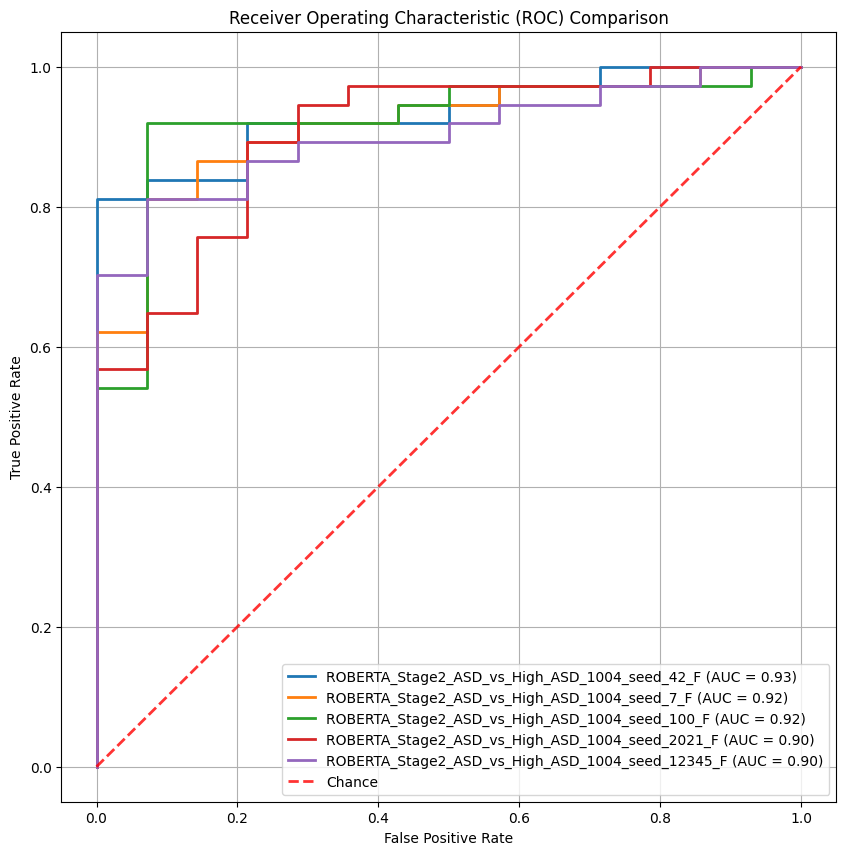

True Labels List: [array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1])]
Predictions List: [array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1,

In [50]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
from sklearn.metrics import (
    f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
)
from scipy.stats import entropy

# =============================================
# 1. Load the Fine-Tuned Model and Tokenizer
# =============================================
# =============================================
# 2. ASD_Dataset Class
# =============================================

# =============================================
# 3. Tokenization / Data Preparation
# =============================================


# =============================================
# 4. Evaluate Model Performance
# =============================================
def evaluate_model_performance2(model, dataloader, device):
    """
    Evaluate the model on the given dataloader and calculate:
    - F1 Score
    - Confusion Matrix
    - TP, FP, TN, FN
    - TPR, FPR
    - AUROC
    - Prediction Entropy

    Returns a dictionary of metrics.
    """
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()

            preds = np.argmax(probs, axis=1)

            all_labels.extend(labels)
            all_probs.extend(probs)  # store the full distribution
            all_preds.extend(preds)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)

    # F1 Score
    f1 = f1_score(all_labels, all_preds)

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = conf_matrix.ravel()

    # TPR, FPR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0.0

    # AUROC (assuming class 1 is the positive class)
    auc_score = roc_auc_score(all_labels, all_probs[:, 1])
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])

    # Prediction Entropy (average of sample entropies)
    sample_entropies = [entropy(prob_dist) for prob_dist in all_probs]
    pred_entropy = np.mean(sample_entropies)

    # Placeholder for Confidence Interval (if needed)
    ci_f1 = (None, None)

    return {
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "TPR": TPR,
        "FPR": FPR,
        "auc_score": auc_score,
        "roc_curve": (fpr, tpr),
        "entropy": pred_entropy,
        "ci_f1": ci_f1,
        "all_labels": all_labels,
        "all_preds": all_preds
    }

# =============================================
# 5. Plot ROC Curve
# =============================================
def plot_roc_curve(fpr, tpr, auc_score, label):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {auc_score:.2f})')

# =============================================
# 6. Main Execution (Example)
# =============================================
if __name__ == "__main__":
    # These are the model paths you specified
    model_paths = [
        # "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/Model/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed__42_nov22F",
        "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_42_F",
        "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_7_F",
        "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_100_F",
        "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_2021_F",
        "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Roberta/plot/ROBERTA_Stage2_ASD_vs_High_ASD_1004_seed_12345_F"
    ]


    # Load your new test data here (replace with actual loading code)
    test_data = test_data  # Assuming 'test_data' is already loaded

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare a figure for ROC curves
    plt.figure(figsize=(10, 10))

    # Store true labels and predictions for optional combined plots
    true_list = []
    pred_list = []

    # =====================================
    # Evaluate Each Model
    # =====================================
    for model_path in model_paths:
        # 1. Load model and tokenizer
        model, tokenizer = load_fine_tuned_model(model_path)
        model.to(device)

        # 2. Prepare test dataset and loader
        test_dataset = prepare_test_dataset(tokenizer, test_data)
        test_loader = DataLoader(test_dataset, batch_size=8)

        # 3. Evaluate
        metrics = evaluate_model_performance2(model, test_loader, device)
        if metrics is None:
            print(f"Metrics for model {model_path} are None. Skipping this model.")
            continue

        # 4. Extract relevant metrics
        f1 = metrics['f1_score']
        conf_matrix = metrics['confusion_matrix']
        TP, FP, TN, FN = metrics['TP'], metrics['FP'], metrics['TN'], metrics['FN']
        TPR, FPR = metrics['TPR'], metrics['FPR']
        auc_score = metrics['auc_score']
        (fpr, tpr) = metrics['roc_curve']
        pred_entropy = metrics['entropy']
        ci_f1 = metrics['ci_f1']  # placeholder (None, None)

        # 5. Print metrics
        print(f"Model: {model_path}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
        print(f"TPR: {TPR:.4f}, FPR: {FPR:.4f}")
        print(f"AUROC: {auc_score:.4f}")
        print(f"Prediction Entropy: {pred_entropy:.4f}")
        print(f"Confidence Interval for F1 (placeholder): {ci_f1}\n")

        # 6. Record labels and predictions for additional analyses
        true_list.append(metrics['all_labels'])
        pred_list.append(metrics['all_preds'])

        # 7. Plot the ROC curve
        plot_roc_curve(fpr, tpr, auc_score, label=os.path.basename(model_path))

    # Finalize ROC plot
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Comparison')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig('roc_curve_comparison.png')
    plt.show()

    # (Optional) Print the collected label/pred arrays
    print("True Labels List:", true_list)
    print("Predictions List:", pred_list)




In [ ]:
# calibrairon curve

In [14]:
import torch
import matplotlib.pyplot as plt
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
from torch.utils.data import DataLoader, Dataset
from scipy.special import softmax
from torchmetrics.classification import BinaryCalibrationError
import torch.nn as nn
# from torch.optim import LBfGS
from torch.optim import Adam 
from sklearn.calibration import calibration_curve



In [15]:
# Evaluate Model and Calculate ECE
def evaluate_model_and_calculate_ece(model, dataloader, device, temperature=None):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

            if temperature is not None:
                logits = logits / temperature

            probs = softmax(logits.cpu().numpy(), axis=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    all_labels = torch.tensor(all_labels)
    all_probs = torch.tensor(all_probs)

    # Calculate ECE using BinaryCalibrationError
    metric = BinaryCalibrationError(n_bins=15, norm='l1')
    ece = metric(all_probs[:, 1], all_labels)
    return ece.item(), all_labels, all_probs

In [16]:
model_path = "/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/Model/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_42_nov22F" #seed=42
output_path = '/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/test_data_ASD_vs_High_original_calib_seed_42_with_probabilities_jan02.csv' #seed 42

In [22]:
# Define the path where you want to save the model and probabilities
path = '/home/skbae/Documents/skbae/ASD/paper/4.Multimodal_RiskST/Model2_High_vs_ASD/Model/'

In [23]:
from sklearn.calibration import calibration_curve, IsotonicRegression
from sklearn.linear_model import LogisticRegression
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import joblib

class TemperatureScaling(nn.Module):
    """Temperature Scaling for logits."""
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, logits):
        return logits / self.temperature

def calculate_ece(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error (ECE)."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bin_boundaries) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() > 0:
            bin_acc = y_true[bin_mask].mean()
            bin_conf = y_prob[bin_mask].mean()
            ece += np.abs(bin_acc - bin_conf) * bin_mask.sum()
    return ece / len(y_true)

# def plot_calibration_curve(y_true, y_prob, n_bins=10):
#     """Plots the calibration curve."""
#     prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

#     plt.figure(figsize=(10, 10))
#     plt.plot([0, 1], [0, 1], linestyle='--')  # Perfect calibration line
#     plt.plot(prob_pred, prob_true, marker='.')
#     plt.xlabel("Mean predicted probability")
#     plt.ylabel("Fraction of positives")
#     plt.title('Calibration plot (Reliability Curve)')
#     plt.grid()
#     plt.show()

Original Model ECE: 0.14222821593284607


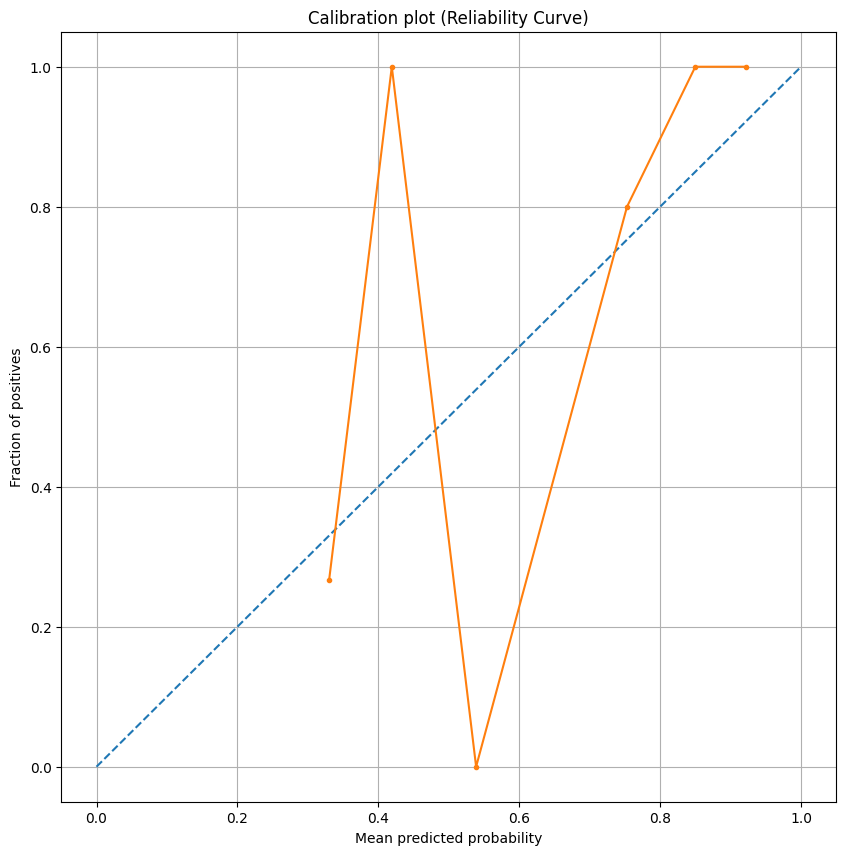

Isotonic Regression ECE: 5.843592631569021e-09


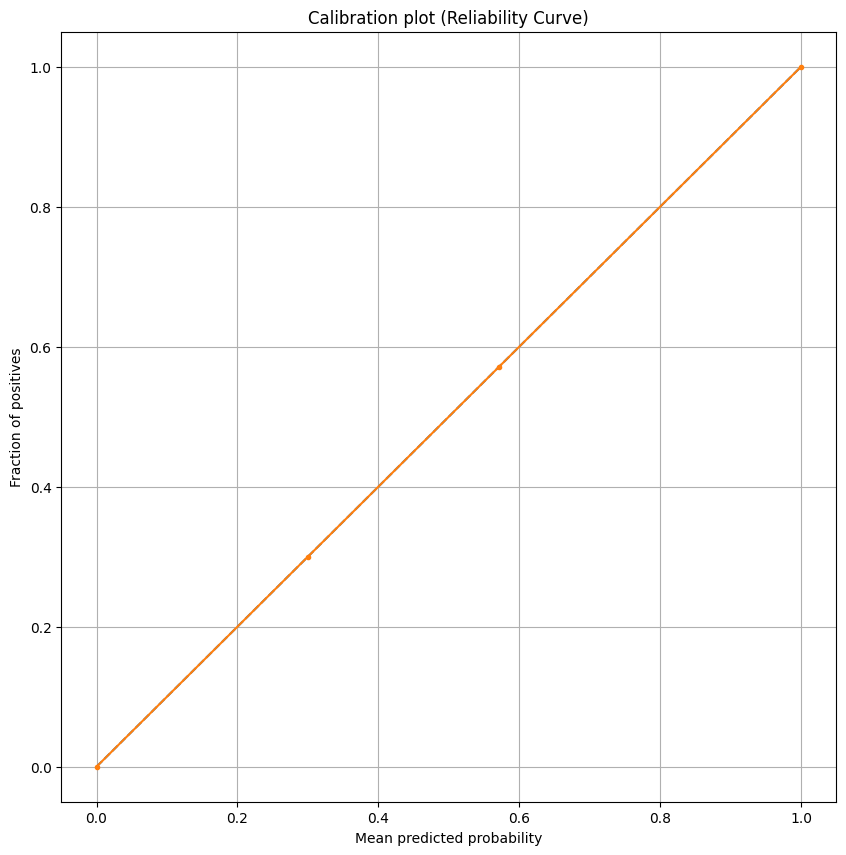

Isotonic calibrated model and probabilities saved successfully.
Loaded calibrated probabilities: [1. 1. 1. 1. 1.]
    SubjectId                                               text  Class  \
0  1023041001  Task Results:  Success of Responded to name ,S...      2   
1  1023052034  Task Results:  Success of Responded to name ,S...      2   
2  1023053011  Task Results:  Failure of  ,Failure of  ,Succe...      2   
3  1023061461  Task Results:  Success of Responded to name ,S...      2   
4  1023080172  Task Results:  Failure of  ,Success of Mimicke...      2   

   label  Original_Probabilities  Calibrated_Probabilities  
0      1                0.805123                       1.0  
1      1                0.811756                       1.0  
2      1                0.826434                       1.0  
3      1                0.914673                       1.0  
4      1                0.894241                       1.0  
Isotonic Regression ECE: 5.843592631569021e-09
Test data combined wit

In [25]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.calibration import calibration_curve, IsotonicRegression

def plot_calibration_curve(y_true, y_prob, n_bins=10):
    """Plots the calibration curve."""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], linestyle='--')  # Perfect calibration line
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title('Calibration plot (Reliability Curve)')
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # Paths to the model
    # model_path = "../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_2021_nov21F" # seed =2021
    # model_path ="../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_Op1_2nd_labelsplit_seed_7_nov21F"
    model_path = model_path #seed=42
    # Load the pre-trained model and tokenizer
    model, tokenizer = load_fine_tuned_model(model_path)

    # Load your validation data here (replace with actual loading code)
    val_data = test_data  # Replace 'test' with your actual validation data (test should be a DataFrame)

    # Prepare the validation dataset
    val_dataset = prepare_validation_dataset(tokenizer, val_data)
    val_loader = DataLoader(val_dataset, batch_size=8)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)



    # Evaluate the model and calculate ECE
    ece, all_labels, all_probs = evaluate_model_and_calculate_ece(model, val_loader, device)
    print(f"Original Model ECE: {ece}")
    plot_calibration_curve(all_labels.cpu().numpy(), all_probs[:, 1].cpu().numpy())


    # Isotonic Regression Calibration
    isotonic = IsotonicRegression(out_of_bounds='clip')
    isotonic.fit(all_probs[:, 1].cpu().numpy(), all_labels.cpu().numpy())
    calibrated_probs_iso = isotonic.transform(all_probs[:, 1].cpu().numpy())
    ece_iso = calculate_ece(all_labels.cpu().numpy(), calibrated_probs_iso)
    print(f"Isotonic Regression ECE: {ece_iso}")
    plot_calibration_curve(all_labels.cpu().numpy(), calibrated_probs_iso)

    # Save the calibrated model and probabilities
    # --- Saving the Model and Probabilities ---

    # Save the isotonic calibrated model using joblib
    joblib.dump(isotonic, os.path.join(path, 'isotonic_calibrated_model_seed_42_ASD_vs_High_seed42_F.pkl'))  # Use os.path.join for proper path construction

    # Save the calibrated probabilities using NumPy
    np.save(os.path.join(path, 'calibrated_probs_iso_seed_42_ASD_vs_High_seed42_F.npy'), calibrated_probs_iso)  # Use os.path.join

    print("Isotonic calibrated model and probabilities saved successfully.")

    # --- Loading the Model and Probabilities ---

    # Load the isotonic calibrated model using joblib
    loaded_isotonic = joblib.load(os.path.join(path, 'isotonic_calibrated_model_seed_42_ASD_vs_High_seed42_F.pkl'))  # Use os.path.join

    # Load the calibrated probabilities using NumPy
    loaded_probs = np.load(os.path.join(path, 'calibrated_probs_iso_seed_42_ASD_vs_High_seed42_F.npy'))  # Use os.path.join


    
    # # joblib.dump(isotonic, './isotonic_calibrated_model_seed_2021_ASD_vs_High_seed7.pkl') # seed7
    # # np.save('./calibrated_probs_iso_seed_2021_ASD_vs_High_seed7.npy', calibrated_probs_iso) # seed7
    # joblib.dump(isotonic, path + './isotonic_calibrated_model_seed_42_ASD_vs_High_seed42.pkl') # seed42
    # np.save(path +'./calibrated_probs_iso_seed_42_ASD_vs_High_seed42.npy', calibrated_probs_iso) # seed42
    # print("Isotonic calibrated model and probabilities saved successfully.")

    # # # Load the model and probabilities for future use
    # # loaded_isotonic = joblib.load('./isotonic_calibrated_model_seed_2021_ASD_vs_High_seed7.pkl')
    # # loaded_probs = np.load('./calibrated_probs_iso_seed_2021_ASD_vs_High_seed7.npy') # seed 7
    # loaded_probs = np.load(path +'./calibrated_probs_iso_seed_42_ASD_vs_High_seed42.npy') # seed42

    # Verify loaded data
    print("Loaded calibrated probabilities:", loaded_probs[:5])  # Print the first 5 probabilities


    # Perform Isotonic Regression Calibration
    isotonic = IsotonicRegression(out_of_bounds='clip')
    isotonic.fit(all_probs[:, 1].cpu().numpy(), all_labels.cpu().numpy())
    # Merge original test data with probabilities
    val_data['Original_Probabilities'] = all_probs[:, 1].cpu().numpy()  # Original model probabilities
    val_data['Calibrated_Probabilities'] = calibrated_probs_iso  # Calibrated probabilities

    # Save the combined dataset
    # output_path = './test_data_ASD_vs_High_original_calib_seed_7_with_probabilities.csv'
    # output_path = output_path #seed 42
    # val_data.to_csv(output_path, index=False)
    # print(f"Test data combined with probabilities saved to {output_path}.")
    #/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/test_data_ASD_vs_High_original_calib_with_probabilities.csv
    # Print the first few rows of the combined dataset
    print(val_data.head())
    print(f"Isotonic Regression ECE: {ece_iso}")

    # Merge original test data with probabilities
    val_data['Original_Probabilities'] = all_probs[:, 1].cpu().numpy()  # Original model probabilities
    val_data['Calibrated_Probabilities'] = calibrated_probs_iso  # Calibrated probabilities

    # Save the combined dataset
    # output_path = './test_data_ASD_vs_High_original_calib_seed_7_with_probabilities.csv'
    output_path = output_path #seed 42
    val_data.to_csv(output_path, index=False)
    print(f"Test data combined with probabilities saved to {output_path}.")
    #/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/test_data_ASD_vs_High_original_calib_with_probabilities.csv
    # Print the first few rows of the combined dataset
    print(val_data.head())


In [ ]:
# 4. correlation and ADOS  risk stratificaiton 

In [1]:
import os
import json
import pandas as pd
from collections import Counter
import numpy as np
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Constants and File Paths ---
HIGH_FILEPATH = "/home/skbae/Documents/skbae/ASD/PJT_Data/Object_Storage/Data/Questions/1004/Survey/T_SurveySatus(ASD_HIGH_20241004).json"
ASD_FILEPATH = "/home/skbae/Documents/skbae/ASD/PJT_Data/Object_Storage/Data/Questions/1004/Survey/T_SurveySatus(ASD_20241004).json"
TD_FILEPATH = "/home/skbae/Documents/skbae/ASD/PJT_Data/Object_Storage/Data/Questions/1004/Survey/T_SurveySatus(NORMAL_20241004).json"
INTERACTION_FILEPATH = '/home/skbae/Documents/skbae/ASD/PJT_Data/Speech/STT_server/text_exc_merged_df_F_1004_Oct18F.csv'
MODEL_OUTPUT_PATH = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
LLM_RESULT_PATH = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/'

# --- Agent 1: Data Preprocessing and Feature Extraction ---

def load_and_preprocess_survey_data(file_path):
    """Loads, preprocesses, and extracts features from survey data."""
    with open(file_path, 'r', encoding='utf-8') as file:
        data_json = json.load(file)

    survey_data = []
    for entry in data_json:
        subject_id = entry['ParticipantInfo']['SubjectId']
        gender = entry['ParticipantInfo']['Gender']
        subject_group = entry['ParticipantInfo']['SubjectGroup']

        eligibility_data = {}
        if subject_group == "ASD_HIGH":
            eligibility_questions = {
                "Family_History": "ELIGIBILITY_ASDHIGH_1_3",
                "Premature_Infant": "ELIGIBILITY_ASDHIGH_1_4",
                "Lanuage_Delay": "ELIGIBILITY_ASDHIGH_1_5",
                "1st_Screening_ASD_Criteria": "ELIGIBILITY_ASDHIGH_1_2",
                "Congenital_Genetic_Disorder": "ELIGIBILITY_ASDHIGH_2_2",
                "History_of_Brain_Damage": "ELIGIBILITY_ASDHIGH_2_3",
                "Seizure_or_Neurological_disease": "ELIGIBILITY_ASDHIGH_2_4"
            }
        elif subject_group == "NORMAL":
            eligibility_questions = {
                "Family_History": "ELIGIBILITY_NORMAL_1_6",
                "1st_Screening_ASD_Criteria": "ELIGIBILITY_NORMAL_1_2",
                "Congenital_Genetic_Disorder": "ELIGIBILITY_NORMAL_2_2",
                "History_of_Brain_Damage": "ELIGIBILITY_NORMAL_2_3",
                "Seizure_or_Neurological_disease": "ELIGIBILITY_NORMAL_2_4"
            }
        elif subject_group == "ASD":
            eligibility_questions = {
                "Family_History": "ELIGIBILITY_ASD_1_3",
                "1st_Screening_ASD_Criteria": "ELIGIBILITY_ASD_1_2",
                "Premature_Infant": "ELIGIBILITY_ASD_1_4",
                "Lanuage_Delay": "ELIGIBILITY_ASD_1_5",
                "2nd_Screening_ASD_Criteria": "ELIGIBILITY_ASD_1_6",
                "Congenital_Genetic_Disorder": "ELIGIBILITY_ASD_2_2",
                "History_of_Brain_Damage": "ELIGIBILITY_ASD_2_3",
                "Seizure_or_Neurological_disease": "ELIGIBILITY_ASD_2_4"
            }
        else:
            eligibility_questions = {}

        for key, question_seq in eligibility_questions.items():
            eligibility_data[key] = next((item['AnswerValue'] for item in entry['DemographicData']['SelectionCriteria']
                                           if item['QuestionSeq'] == question_seq), 'N/A')

        survey_data.append({
            "Subject_Id": subject_id,
            "Gender": gender,
            "Class/ASD": subject_group,
            **eligibility_data
        })

    return pd.DataFrame(survey_data)

def standardize_eligibility_criteria(df):
    """Standardizes eligibility criteria to numerical values (0 or 1)."""
    if '1st_Screening_ASD_Criteria' in df.columns:
        df['1st_Screening_ASD_Criteria'] = df['1st_Screening_ASD_Criteria'].replace({'2': '0', '1': '1'})
    if 'Family_History' in df.columns:
        df['Family_History'] = df['Family_History'].replace({'2': '0', 'Y': '1', 'N': '0'})
    if 'Premature_Infant' in df.columns:
        df['Premature_Infant'] = df['Premature_Infant'].replace({'2': '0', '1': '1'})
    if 'Lanuage_Delay' in df.columns:
        df['Lanuage_Delay'] = df['Lanuage_Delay'].replace({'2': '0', '1': '1'})
    if 'Congenital_Genetic_Disorder' in df.columns:
        df['Congenital_Genetic_Disorder'] = df['Congenital_Genetic_Disorder'].replace({'2': '0', 'Y': '1', 'N': '0'})
    if 'History_of_Brain_Damage' in df.columns:
        df['History_of_Brain_Damage'] = df['History_of_Brain_Damage'].replace({'2': '0', 'Y': '1', 'N': '0'})
    if 'Seizure_or_Neurological_disease' in df.columns:
        df['Seizure_or_Neurological_disease'] = df['Seizure_or_Neurological_disease'].replace({'2': '0', 'Y': '1', 'N': '0'})
    if '2nd_Screening_ASD_Criteria' in df.columns:
        df['2nd_Screening_ASD_Criteria'] = df['2nd_Screening_ASD_Criteria'].replace({'2':'0', '1': '1'})
    return df


In [2]:
# --- Agent 2: ADOS Data Processing ---

def load_and_process_ados_data(filepath, group):
    """Loads and processes ADOS data from JSON files."""
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)

    codebook_form_cd_values = ["ADOS2_MOD_T_1848", "ADOS2_MOD_1_1848", "ADOS2_MOD_2_1848", "ADOS2_MOD_3_1848"]
    data_dict = {code: {"SubjectId": [], "QuestionSeq": [], "AnswerValue": [], "TrialIndex": [], "Group": []} for code in codebook_form_cd_values}

    for participant in data:
        subject_id = participant["ParticipantInfo"]["SubjectId"]
        for section in participant:
            if section not in ["ParticipantInfo", "DemographicData"]:
                for survey in participant[section]:
                    codebook_form_cd = survey.get("CodeBookFormCd")
                    if codebook_form_cd in codebook_form_cd_values and "QuestionResult" in survey:
                        trial_index = survey.get("TrialIndex")
                        for question in survey["QuestionResult"]:
                            if question["QuestionSeq"].startswith(codebook_form_cd + "_"):
                                data_dict[codebook_form_cd]["SubjectId"].append(subject_id)
                                data_dict[codebook_form_cd]["QuestionSeq"].append(question["QuestionSeq"])
                                data_dict[codebook_form_cd]["AnswerValue"].append(question["AnswerValue"])
                                data_dict[codebook_form_cd]["TrialIndex"].append(trial_index)
                                data_dict[codebook_form_cd]["Group"].append(group)

    dataframes = {code: pd.DataFrame(data) for code, data in data_dict.items()}
    return dataframes

def process_ados_dataframe(df):
    """Processes ADOS dataframes to pivot and standardize format."""
    df = df.drop_duplicates(subset=["SubjectId", "QuestionSeq"])
    pivot_df = df.pivot(index="SubjectId", columns="QuestionSeq", values="AnswerValue").reset_index()
    column_order = ["SubjectId"] + sorted(df["QuestionSeq"].unique())
    existing_columns = [col for col in column_order if col in pivot_df.columns]
    processed_df = pivot_df[existing_columns]
    group_df = df[["SubjectId", "Group"]].drop_duplicates(subset=["SubjectId"])
    processed_df = processed_df.merge(group_df, on="SubjectId", how="left")
    cols = processed_df.columns.tolist()
    cols.append(cols.pop(cols.index('Group')))
    processed_df = processed_df[cols]
    return processed_df

In [3]:
# --- Agent 4: Correlation Analysis and Risk Stratification ---

def categorize_risk(prob, threshold1=0.3, threshold2=0.7):
    """Categorizes predicted risk based on probability."""
    if prob < threshold1:
        return 'Low Risk'
    elif threshold1 <= prob <= threshold2:
        return 'Moderate Risk'
    else:
        return 'High Risk'

def categorize_ados_risk(score, threshold1=7, threshold2=13):
    """Categorizes ADOS risk based on SUM_T score."""
    if score < threshold1:
        return 'Low Risk'
    elif threshold1 <= score <= threshold2:
        return 'Moderate Risk'
    else:
        return 'High Risk'

def combined_risk(predicted_risk, ados_risk):
    """Combines predicted risk and ADOS risk for a final risk category."""
    if predicted_risk == 'High Risk' and ados_risk == 'High Risk':
        return 'High Risk'
    elif (predicted_risk == 'Moderate Risk' and ados_risk == 'High Risk') or \
         (predicted_risk == 'High Risk' and ados_risk == 'Moderate Risk'):
        return 'Moderate Risk'
    else:
        return 'Low Risk'

Pearson Correlation (SUM_T2): 0.8299342542991663, p-value: 1.687902489065146e-13
Spearman Correlation (SUM_T2): 0.8889686120614959, p-value: 1.48466737131774e-17

Correlation Results (Mean Calibrated Probabilities vs. ADOS SUM_T):
  Pearson Correlation: 0.830 (P-value: 1.688e-13)
  Spearman Correlation: 0.889 (P-value: 1.485e-17)


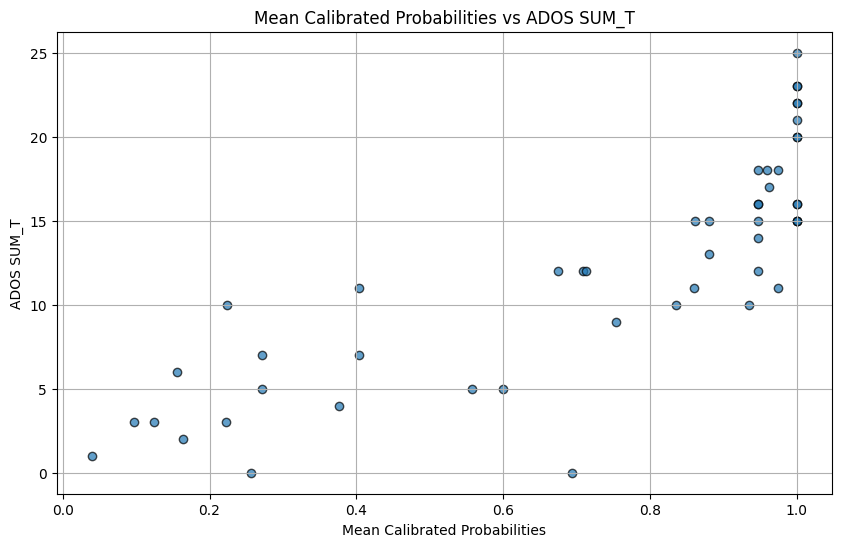

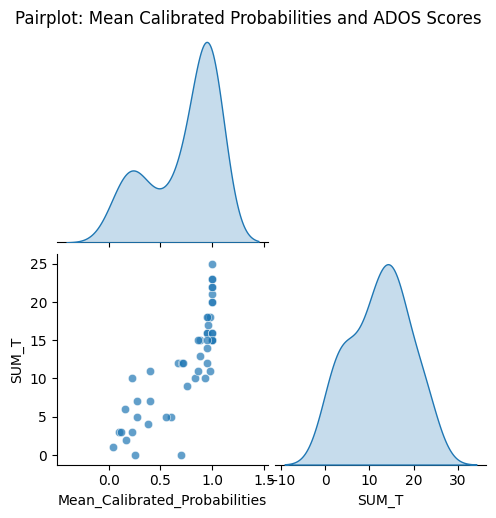

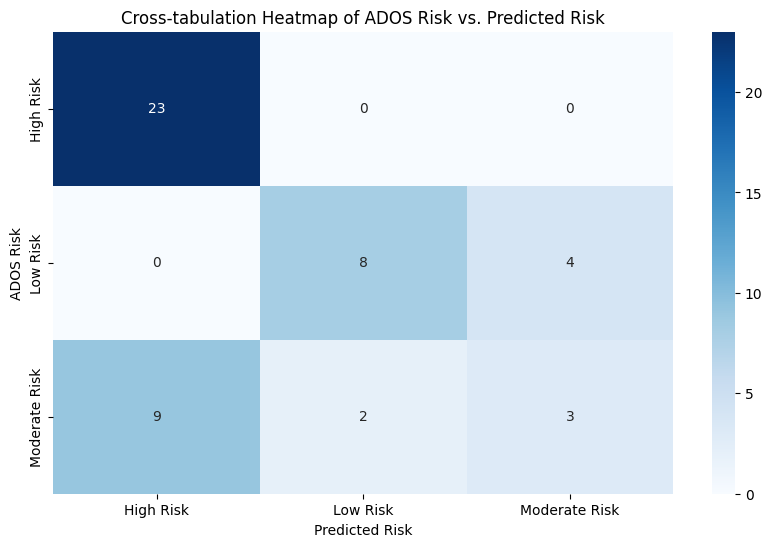

Analysis and risk stratification complete.


In [4]:
# --- Main Workflow ---

if __name__ == "__main__":
    # ... (Code for Data Preprocessing and ADOS Data Processing - from previous response) ...

    # --- 3. Merge Model Predictions and ADOS Data ---
    # Load the combined ADOS dataset
    # combined_ADOS2_MOD = pd.read_csv(f'{MODEL_OUTPUT_PATH}/combined_ADOS2_MOD_nov20_updated.csv')

    path = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
    combined_ADOS2_MOD = pd.read_csv(f'{path}/combined_ADOS2_MOD_nov20.csv')
    combined_ADOS2_MOD_2 = combined_ADOS2_MOD


    # Define the base path to the CSV files
    base_path = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/'

    # Define the file names and corresponding seed numbers
    file_names = [
        'test_data_ASD_vs_High_original_calib_seed_42_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_100_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_2021_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_7_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_12345_with_probabilities.csv'
    ]
    seeds = [42, 100, 2021, 7, 12345]

    # Combine the base path with file names to get full paths
    file_paths = [base_path + file_name for file_name in file_names]

    # Load the data from each file into a list of DataFrames
    data_frames = [pd.read_csv(file_path) for file_path in file_paths]

    # Merge each test data with the combined dataset using suffixes to avoid duplicate columns
    for i, df in enumerate(data_frames):
        combined_ADOS2_MOD = combined_ADOS2_MOD.merge(df, on='SubjectId', how='inner', suffixes=('', f'_seed{seeds[i]}'))

    combined_ADOS2_MOD_2 = combined_ADOS2_MOD

    # Rename columns for seed 42 (original and calibrated probabilities) - do this only once!
    if 'Original_Probabilities' in combined_ADOS2_MOD_2.columns:
      combined_ADOS2_MOD_2.rename(columns={
          'Original_Probabilities': 'Original_Probabilities_seed42',
          'Calibrated_Probabilities': 'Calibrated_Probabilities_seed42'
      }, inplace=True)

    # --- 4. Statistical Analysis (Chi-Square, Post-Hoc) ---
    # Load patient combined info 
    path2='/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
    combined_info = pd.read_csv(f'{path2}/patient_combined_info_1004_Nov14.csv')
    # patient_combined_info = pd.read_csv(f'{path}/patient_combined_info_1004_Nov14.csv')

    data = combined_info
    variables = ['Gender', 'Family_History', 'Premature_Infant', 'Lanuage_Delay']


    # --- 5. Correlation Analysis and Risk Stratification ---
    # Prepare data for correlation analysis
    # Ensure required columns exist
    original_prob_columns = [f'Original_Probabilities_seed{seed}' for seed in seeds]
    calibrated_prob_columns = [f'Calibrated_Probabilities_seed{seed}' for seed in seeds]
    required_columns = ['SUM_T'] + original_prob_columns + calibrated_prob_columns
    missing_columns = [col for col in required_columns if col not in combined_ADOS2_MOD_2.columns]
    if missing_columns:
        raise KeyError(f"The following required columns are missing: {missing_columns}")

    # Calculate mean calibrated probabilities
    combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'] = combined_ADOS2_MOD_2[calibrated_prob_columns].mean(axis=1)

    # Correlation Analysis
    #1st
    # Initialize the scaler
    scaler = MinMaxScaler()
    # Scale the 'SUM_T' column using MinMaxScaler and create a new variable 'SUM_T2'
    combined_ADOS2_MOD_2['SUM_T2'] = scaler.fit_transform(combined_ADOS2_MOD_2['SUM_T'].values.reshape(-1, 1))

    # Calculate Pearson and Spearman Correlations using the new scaled variable 'SUM_T2'
    pearson_corr, p_value_pearson = pearsonr(combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'], combined_ADOS2_MOD_2['SUM_T2'])
    spearman_corr, p_value_spearman = spearmanr(combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'], combined_ADOS2_MOD_2['SUM_T2'])

    # Print or use the correlation coefficients as needed
    print(f"Pearson Correlation (SUM_T2): {pearson_corr}, p-value: {p_value_pearson}")
    print(f"Spearman Correlation (SUM_T2): {spearman_corr}, p-value: {p_value_spearman}")


    #2nd
    pearson_corr, p_value_pearson = pearsonr(combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'], combined_ADOS2_MOD_2['SUM_T'])
    spearman_corr, p_value_spearman = spearmanr(combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'], combined_ADOS2_MOD_2['SUM_T'])

    print("\nCorrelation Results (Mean Calibrated Probabilities vs. ADOS SUM_T):")
    print(f"  Pearson Correlation: {pearson_corr:.3f} (P-value: {p_value_pearson:.3e})")
    print(f"  Spearman Correlation: {spearman_corr:.3f} (P-value: {p_value_spearman:.3e})")

    # Risk Stratification
    combined_ADOS2_MOD_2['Predicted_Risk'] = combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'].apply(categorize_risk)
    combined_ADOS2_MOD_2['ADOS_Risk'] = combined_ADOS2_MOD_2['SUM_T'].apply(categorize_ados_risk)
    combined_ADOS2_MOD_2['Combined_Risk'] = combined_ADOS2_MOD_2.apply(lambda row: combined_risk(row['Predicted_Risk'], row['ADOS_Risk']), axis=1)

    # --- 6. Visualization ---

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'], combined_ADOS2_MOD_2['SUM_T'], alpha=0.7, edgecolor='black')
    plt.title('Mean Calibrated Probabilities vs ADOS SUM_T')
    plt.xlabel('Mean Calibrated Probabilities')
    plt.ylabel('ADOS SUM_T')
    plt.grid(True)
    plt.show()

    # Pairplot
    columns_to_plot = ['Mean_Calibrated_Probabilities', 'SUM_T']
    sns.pairplot(combined_ADOS2_MOD_2[columns_to_plot], diag_kind='kde', corner=True, plot_kws={'alpha': 0.7})
    plt.suptitle('Pairplot: Mean Calibrated Probabilities and ADOS Scores', y=1.02)
    plt.show()

    # Heatmap for Risk Stratification
    cross_tab = pd.crosstab(combined_ADOS2_MOD_2['ADOS_Risk'], combined_ADOS2_MOD_2['Predicted_Risk'])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
    plt.title('Cross-tabulation Heatmap of ADOS Risk vs. Predicted Risk')
    plt.xlabel('Predicted Risk')
    plt.ylabel('ADOS Risk')
    plt.show()

    print("Analysis and risk stratification complete.")

In [ ]:
# optin 2 : Teredhold 

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ... (Your other code for data loading, preprocessing, etc.) ...

# --- Agent 4: Correlation Analysis and Risk Stratification ---

def categorize_risk(prob, threshold1=0.3, threshold2=0.7):
    """Categorizes predicted risk based on probability."""
    if prob < threshold1:
        return 'Low Risk'
    elif threshold1 <= prob <= threshold2:
        return 'Moderate Risk'
    else:
        return 'High Risk'

def categorize_ados_risk(score, threshold1=7, threshold2=13):
    """Categorizes ADOS risk based on SUM_T score."""
    if score < threshold1:
        return 'Low Risk'
    elif threshold1 <= score <= threshold2:
        return 'Moderate Risk'
    else:
        return 'High Risk'

def combined_risk(predicted_risk, ados_risk):
    """Combines predicted risk and ADOS risk for a final risk category."""
    if predicted_risk == 'High Risk' and ados_risk == 'High Risk':
        return 'High Risk'
    elif (predicted_risk == 'Moderate Risk' and ados_risk == 'High Risk') or \
         (predicted_risk == 'High Risk' and ados_risk == 'Moderate Risk'):
        return 'Moderate Risk'
    else:
        return 'Low Risk'

def optimize_thresholds(data, prob_column='Mean_Calibrated_Probabilities', ados_score_column='SUM_T', ados_thresholds=[7, 13]):
    """
    Optimizes the thresholds for categorizing predicted probabilities into risk groups 
    to maximize agreement with ADOS risk categories.

    Args:
        data (pd.DataFrame): The DataFrame containing the predicted probabilities and ADOS scores.
        prob_column (str): The name of the column containing the predicted probabilities.
        ados_score_column (str): The name of the column containing the ADOS SUM_T scores.
        ados_thresholds (list): A list of two values representing the lower and upper thresholds for ADOS risk categorization.

    Returns:
        tuple: A tuple containing:
            - best_thresholds (list): The optimized thresholds for predicted probabilities.
            - best_agreement (float): The best agreement score (accuracy or F1-score) achieved.
            - best_heatmap_data (pd.DataFrame): The cross-tabulation data (for the heatmap) at the best thresholds.
            - threshold_search_results (list): a list of the agreement score for different threshold values.
    """
    best_thresholds = [0.3, 0.7]  # Default initial thresholds
    best_agreement = 0
    best_heatmap_data = None
    
    threshold_search_results = []

    # Iterate through a range of possible thresholds
    for t1 in np.arange(0.1, 0.5, 0.05):  # Adjust range and step as needed
        for t2 in np.arange(t1 + 0.1, 0.9, 0.05):
            # Categorize predicted risk
            data['Predicted_Risk'] = data[prob_column].apply(lambda prob: categorize_risk(prob, t1, t2))

            # Categorize ADOS risk (using provided thresholds)
            data['ADOS_Risk'] = data[ados_score_column].apply(lambda score: categorize_ados_risk(score, ados_thresholds[0], ados_thresholds[1]))

            # Calculate agreement (e.g., accuracy or F1-score)
            agreement = accuracy_score(data['ADOS_Risk'], data['Predicted_Risk'])
            # agreement = f1_score(data['ADOS_Risk'], data['Predicted_Risk'], average='weighted') # You can also use F1-score

            # Store agreement scores with thresholds
            threshold_search_results.append({'threshold1': t1, 'threshold2': t2, 'agreement': agreement})
            
            # Update best thresholds if current agreement is better
            if agreement > best_agreement:
                best_agreement = agreement
                best_thresholds = [t1, t2]
                best_heatmap_data = pd.crosstab(data['ADOS_Risk'], data['Predicted_Risk'])

    return best_thresholds, best_agreement, best_heatmap_data, threshold_search_results


In [8]:
def optimize_thresholds(data, prob_column='Mean_Calibrated_Probabilities', ados_score_column='SUM_T', ados_thresholds=[7, 13]):
    """
    Optimizes the thresholds for categorizing predicted probabilities into risk groups 
    to maximize agreement with ADOS risk categories.

    Args:
        data (pd.DataFrame): The DataFrame containing the predicted probabilities and ADOS scores.
        prob_column (str): The name of the column containing the predicted probabilities.
        ados_score_column (str): The name of the column containing the ADOS SUM_T scores.
        ados_thresholds (list): A list of two values representing the lower and upper thresholds for ADOS risk categorization.

    Returns:
        tuple: A tuple containing:
            - best_thresholds (list): The optimized thresholds for predicted probabilities.
            - best_agreement (float): The best agreement score (accuracy or F1-score) achieved.
            - best_heatmap_data (pd.DataFrame): The cross-tabulation data (for the heatmap) at the best thresholds.
            - threshold_search_results (list): a list of the agreement score for different threshold values.
    """
    best_thresholds = [0.3, 0.7]  # Default initial thresholds
    best_agreement = 0
    best_heatmap_data = None
    
    threshold_search_results = []

    # Iterate through a range of possible thresholds
    for t1 in np.arange(0.1, 0.5, 0.05):  # Adjust range and step as needed
        for t2 in np.arange(t1 + 0.1, 0.9, 0.05):
            # Categorize predicted risk
            data['Predicted_Risk'] = data[prob_column].apply(lambda prob: categorize_risk(prob, t1, t2))

            # Categorize ADOS risk (using provided thresholds)
            data['ADOS_Risk'] = data[ados_score_column].apply(lambda score: categorize_ados_risk(score, ados_thresholds[0], ados_thresholds[1]))

            # Calculate agreement (e.g., accuracy or F1-score)
            agreement = accuracy_score(data['ADOS_Risk'], data['Predicted_Risk'])
            # agreement = f1_score(data['ADOS_Risk'], data['Predicted_Risk'], average='weighted') # You can also use F1-score

            # Store agreement scores with thresholds
            threshold_search_results.append({'threshold1': t1, 'threshold2': t2, 'agreement': agreement})
            
            # Update best thresholds if current agreement is better
            if agreement > best_agreement:
                best_agreement = agreement
                best_thresholds = [t1, t2]
                best_heatmap_data = pd.crosstab(data['ADOS_Risk'], data['Predicted_Risk'])

    return best_thresholds, best_agreement, best_heatmap_data, threshold_search_results



Best Thresholds (Predicted Probabilities): [0.40000000000000013, 0.8500000000000004]
Best Agreement (Accuracy or F1-score): 0.7959


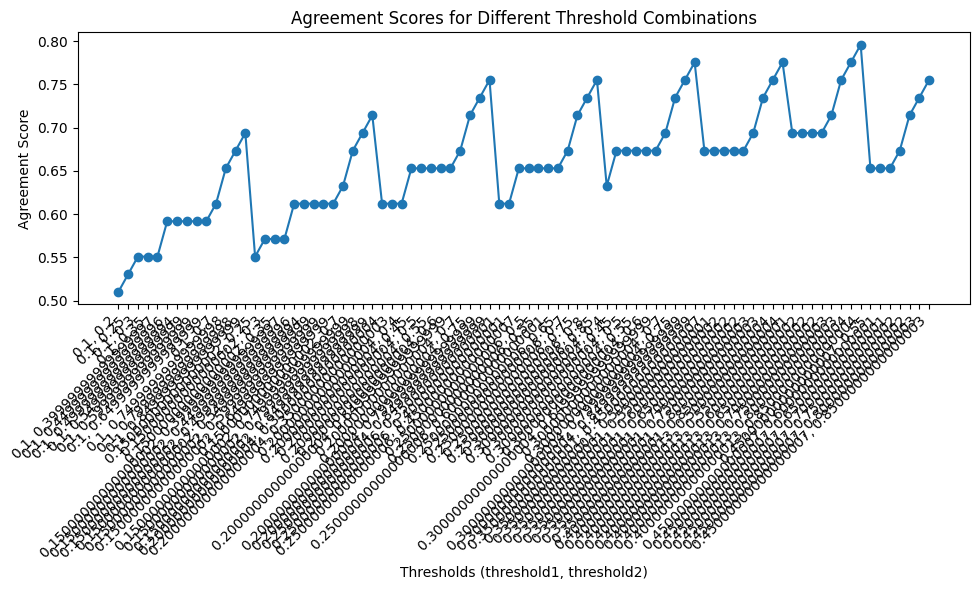

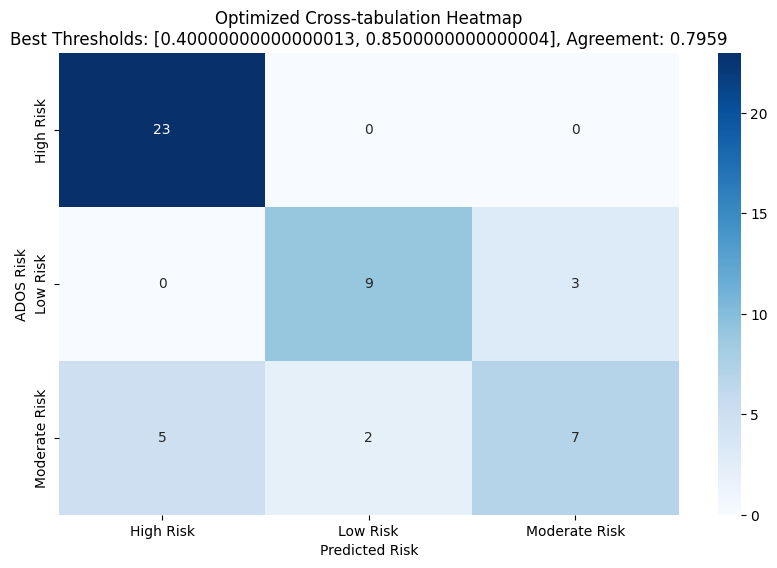

In [9]:
if __name__ == "__main__":
    # ... (Code for Data Preprocessing and ADOS Data Processing - from previous response) ...

    # --- 3. Merge Model Predictions and ADOS Data ---
    # Load the combined ADOS dataset
    # combined_ADOS2_MOD = pd.read_csv(f'{MODEL_OUTPUT_PATH}/combined_ADOS2_MOD_nov20_updated.csv')

    path = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
    combined_ADOS2_MOD = pd.read_csv(f'{path}/combined_ADOS2_MOD_nov20.csv')
    combined_ADOS2_MOD_2 = combined_ADOS2_MOD


    # Define the base path to the CSV files
    base_path = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/'

    # Define the file names and corresponding seed numbers
    file_names = [
        'test_data_ASD_vs_High_original_calib_seed_42_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_100_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_2021_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_7_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_12345_with_probabilities.csv'
    ]
    seeds = [42, 100, 2021, 7, 12345]

    # Combine the base path with file names to get full paths
    file_paths = [base_path + file_name for file_name in file_names]

    # Load the data from each file into a list of DataFrames
    data_frames = [pd.read_csv(file_path) for file_path in file_paths]

    # Merge each test data with the combined dataset using suffixes to avoid duplicate columns
    for i, df in enumerate(data_frames):
        combined_ADOS2_MOD = combined_ADOS2_MOD.merge(df, on='SubjectId', how='inner', suffixes=('', f'_seed{seeds[i]}'))

    combined_ADOS2_MOD_2 = combined_ADOS2_MOD

    # Rename columns for seed 42 (original and calibrated probabilities) - do this only once!
    if 'Original_Probabilities' in combined_ADOS2_MOD_2.columns:
      combined_ADOS2_MOD_2.rename(columns={
          'Original_Probabilities': 'Original_Probabilities_seed42',
          'Calibrated_Probabilities': 'Calibrated_Probabilities_seed42'
      }, inplace=True)

    # --- 4. Statistical Analysis (Chi-Square, Post-Hoc) ---
    # Load patient combined info 
    path2='/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
    combined_info = pd.read_csv(f'{path2}/patient_combined_info_1004_Nov14.csv')
    # patient_combined_info = pd.read_csv(f'{path}/patient_combined_info_1004_Nov14.csv')

    data = combined_info
    variables = ['Gender', 'Family_History', 'Premature_Infant', 'Lanuage_Delay']


    # --- 5. Correlation Analysis and Risk Stratification ---

    # Prepare data for correlation analysis
    original_prob_columns = [f'Original_Probabilities_seed{seed}' for seed in seeds]
    calibrated_prob_columns = [f'Calibrated_Probabilities_seed{seed}' for seed in seeds]
    required_columns = ['SUM_T'] + original_prob_columns + calibrated_prob_columns
    missing_columns = [col for col in required_columns if col not in combined_ADOS2_MOD_2.columns]
    if missing_columns:
        print(f"Warning: The following required columns are missing: {missing_columns}")

    # Calculate mean calibrated probabilities
    combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'] = combined_ADOS2_MOD_2[calibrated_prob_columns].mean(axis=1, skipna=True)

    # Optimize thresholds
    best_thresholds, best_agreement, best_heatmap_data, threshold_search_results_df = optimize_thresholds(combined_ADOS2_MOD_2)

    print(f"\nBest Thresholds (Predicted Probabilities): {best_thresholds}")
    print(f"Best Agreement (Accuracy or F1-score): {best_agreement:.4f}")


    # Convert the list of dictionaries to a DataFrame
    threshold_search_results_df = pd.DataFrame(threshold_search_results_df) # Create DataFrame from threshold_search_results

    # Plot agreement scores vs. thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_search_results_df['threshold1'].astype(str) + ', ' + threshold_search_results_df['threshold2'].astype(str), threshold_search_results_df['agreement'], marker='o')
    plt.title('Agreement Scores for Different Threshold Combinations')
    plt.xlabel('Thresholds (threshold1, threshold2)')
    plt.ylabel('Agreement Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Apply optimized thresholds for risk stratification (using best_thresholds)
    combined_ADOS2_MOD_2['Predicted_Risk'] = combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'].apply(
        lambda prob: categorize_risk(prob, best_thresholds[0], best_thresholds[1])
    )
    combined_ADOS2_MOD_2['ADOS_Risk'] = combined_ADOS2_MOD_2['SUM_T'].apply(categorize_ados_risk)
    combined_ADOS2_MOD_2['Combined_Risk'] = combined_ADOS2_MOD_2.apply(
        lambda row: combined_risk(row['Predicted_Risk'], row['ADOS_Risk']), axis=1
    )


    # # Convert the list of dictionaries to a DataFrame
    # threshold_search_results_df = pd.DataFrame(threshold_search_results)

    # # Plot agreement scores vs. thresholds
    # plt.figure(figsize=(10, 6))
    # plt.plot(threshold_search_results_df['threshold1'].astype(str) + ', ' + threshold_search_results_df['threshold2'].astype(str), threshold_search_results_df['agreement'], marker='o')
    # plt.title('Agreement Scores for Different Threshold Combinations')
    # plt.xlabel('Thresholds (threshold1, threshold2)')
    # plt.ylabel('Agreement Score')
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()

    # # Apply optimized thresholds for risk stratification (using best_thresholds)
    # combined_ADOS2_MOD_2['Predicted_Risk'] = combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'].apply(
    #     lambda prob: categorize_risk(prob, best_thresholds[0], best_thresholds[1])
    # )
    # combined_ADOS2_MOD_2['ADOS_Risk'] = combined_ADOS2_MOD_2['SUM_T'].apply(categorize_ados_risk)
    # combined_ADOS2_MOD_2['Combined_Risk'] = combined_ADOS2_MOD_2.apply(
    #     lambda row: combined_risk(row['Predicted_Risk'], row['ADOS_Risk']), axis=1
    # )

    # --- 6. Visualization ---

    # Heatmap with optimized thresholds
    plt.figure(figsize=(10, 6))
    sns.heatmap(best_heatmap_data, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Optimized Cross-tabulation Heatmap\nBest Thresholds: {best_thresholds}, Agreement: {best_agreement:.4f}')
    plt.xlabel('Predicted Risk')
    plt.ylabel('ADOS Risk')
    plt.show()



Best Thresholds (Predicted Probabilities): [0.40000000000000013, 0.8500000000000004]
Best Agreement (Accuracy or F1-score): 0.7959


/tmp/ipykernel_396184/3004593438.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_data['Predicted_Risk'] = class_data['Mean_Calibrated_Probabilities'].apply(
/tmp/ipykernel_396184/3004593438.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_data['ADOS_Risk'] = class_data['SUM_T'].apply(categorize_ados_risk)


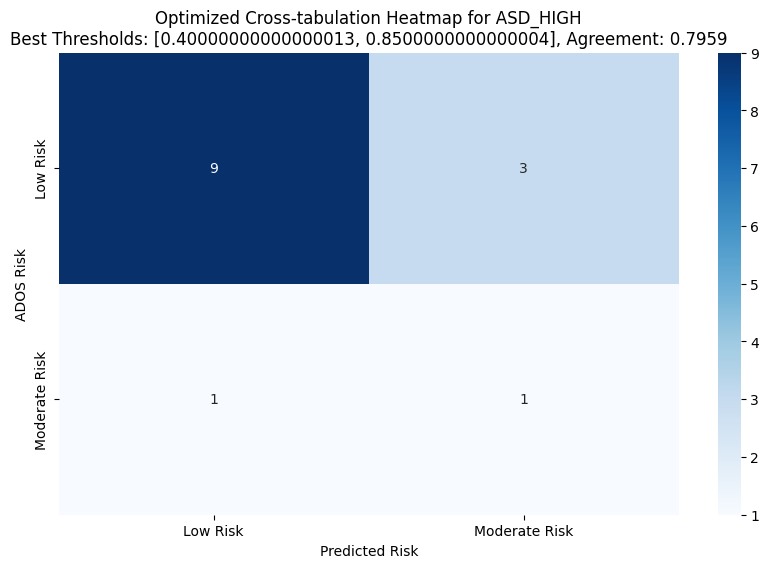

/tmp/ipykernel_396184/3004593438.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_data['Predicted_Risk'] = class_data['Mean_Calibrated_Probabilities'].apply(
/tmp/ipykernel_396184/3004593438.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_data['ADOS_Risk'] = class_data['SUM_T'].apply(categorize_ados_risk)


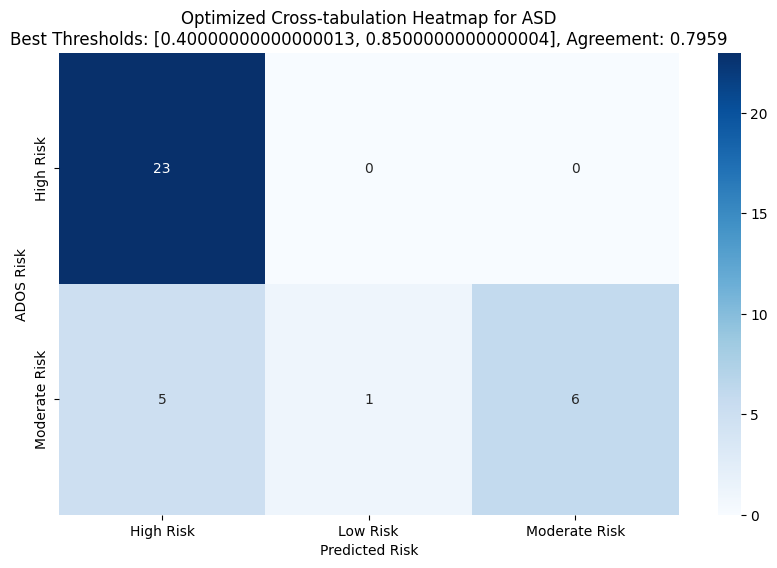

In [10]:
if __name__ == "__main__":
    # ... (Code for Data Preprocessing and ADOS Data Processing - from previous response) ...

    # --- 3. Merge Model Predictions and ADOS Data ---
    # Load the combined ADOS dataset
    # combined_ADOS2_MOD = pd.read_csv(f'{MODEL_OUTPUT_PATH}/combined_ADOS2_MOD_nov20_updated.csv')

    path = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
    combined_ADOS2_MOD = pd.read_csv(f'{path}/combined_ADOS2_MOD_nov20.csv')
    combined_ADOS2_MOD_2 = combined_ADOS2_MOD


    # Define the base path to the CSV files
    base_path = '/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/'

    # Define the file names and corresponding seed numbers
    file_names = [
        'test_data_ASD_vs_High_original_calib_seed_42_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_100_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_2021_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_7_with_probabilities.csv',
        'test_data_ASD_vs_High_original_calib_seed_12345_with_probabilities.csv'
    ]
    seeds = [42, 100, 2021, 7, 12345]

    # Combine the base path with file names to get full paths
    file_paths = [base_path + file_name for file_name in file_names]

    # Load the data from each file into a list of DataFrames
    data_frames = [pd.read_csv(file_path) for file_path in file_paths]

    # Merge each test data with the combined dataset using suffixes to avoid duplicate columns
    for i, df in enumerate(data_frames):
        combined_ADOS2_MOD = combined_ADOS2_MOD.merge(df, on='SubjectId', how='inner', suffixes=('', f'_seed{seeds[i]}'))

    combined_ADOS2_MOD_2 = combined_ADOS2_MOD

    # Rename columns for seed 42 (original and calibrated probabilities) - do this only once!
    if 'Original_Probabilities' in combined_ADOS2_MOD_2.columns:
      combined_ADOS2_MOD_2.rename(columns={
          'Original_Probabilities': 'Original_Probabilities_seed42',
          'Calibrated_Probabilities': 'Calibrated_Probabilities_seed42'
      }, inplace=True)

    # --- 4. Statistical Analysis (Chi-Square, Post-Hoc) ---
    # Load patient combined info 
    path2='/home/skbae/Documents/skbae/ASD/PJT_Data/Questions/Work/llm/result/DataFlow'
    combined_info = pd.read_csv(f'{path2}/patient_combined_info_1004_Nov14.csv')
    # patient_combined_info = pd.read_csv(f'{path}/patient_combined_info_1004_Nov14.csv')

    data = combined_info
    variables = ['Gender', 'Family_History', 'Premature_Infant', 'Lanuage_Delay']


    # --- 5. Correlation Analysis and Risk Stratification ---

    # Prepare data for correlation analysis
    original_prob_columns = [f'Original_Probabilities_seed{seed}' for seed in seeds]
    calibrated_prob_columns = [f'Calibrated_Probabilities_seed{seed}' for seed in seeds]
    required_columns = ['SUM_T'] + original_prob_columns + calibrated_prob_columns
    missing_columns = [col for col in required_columns if col not in combined_ADOS2_MOD_2.columns]
    if missing_columns:
        print(f"Warning: The following required columns are missing: {missing_columns}")

    # Calculate mean calibrated probabilities
    combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'] = combined_ADOS2_MOD_2[calibrated_prob_columns].mean(axis=1, skipna=True)

    # Optimize thresholds
    best_thresholds, best_agreement, best_heatmap_data, threshold_search_results_df = optimize_thresholds(combined_ADOS2_MOD_2)

    print(f"\nBest Thresholds (Predicted Probabilities): {best_thresholds}")
    print(f"Best Agreement (Accuracy or F1-score): {best_agreement:.4f}")


    # # Convert the list of dictionaries to a DataFrame
    # threshold_search_results_df = pd.DataFrame(threshold_search_results_df) # Create DataFrame from threshold_search_results

    # # Plot agreement scores vs. thresholds
    # plt.figure(figsize=(10, 6))
    # plt.plot(threshold_search_results_df['threshold1'].astype(str) + ', ' + threshold_search_results_df['threshold2'].astype(str), threshold_search_results_df['agreement'], marker='o')
    # plt.title('Agreement Scores for Different Threshold Combinations')
    # plt.xlabel('Thresholds (threshold1, threshold2)')
    # plt.ylabel('Agreement Score')
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()

    # Apply optimized thresholds for risk stratification (using best_thresholds)
    combined_ADOS2_MOD_2['Predicted_Risk'] = combined_ADOS2_MOD_2['Mean_Calibrated_Probabilities'].apply(
        lambda prob: categorize_risk(prob, best_thresholds[0], best_thresholds[1])
    )
    combined_ADOS2_MOD_2['ADOS_Risk'] = combined_ADOS2_MOD_2['SUM_T'].apply(categorize_ados_risk)
    combined_ADOS2_MOD_2['Combined_Risk'] = combined_ADOS2_MOD_2.apply(
        lambda row: combined_risk(row['Predicted_Risk'], row['ADOS_Risk']), axis=1
    )



   # 각 클래스에 대해 히트맵을 그리기
    class_labels = combined_ADOS2_MOD_2['Group'].unique()
    for class_label in class_labels:
        class_data = combined_ADOS2_MOD_2[combined_ADOS2_MOD_2['Group'] == class_label]
    
        # 예측된 위험 분류
        class_data['Predicted_Risk'] = class_data['Mean_Calibrated_Probabilities'].apply(
            lambda prob: categorize_risk(prob, best_thresholds[0], best_thresholds[1])
        )
    
        # ADOS 위험 분류
        class_data['ADOS_Risk'] = class_data['SUM_T'].apply(categorize_ados_risk)
    
        # 교차표 생성
        cross_tab = pd.crosstab(class_data['ADOS_Risk'], class_data['Predicted_Risk'], rownames=['ADOS Risk'], colnames=['Predicted Risk'])
    
        # 히트맵 그리기
        plt.figure(figsize=(10, 6))
        sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Optimized Cross-tabulation Heatmap for {class_label}\nBest Thresholds: {best_thresholds}, Agreement: {best_agreement:.4f}')
        plt.xlabel('Predicted Risk')
        plt.ylabel('ADOS Risk')
        plt.show()